# Statistical analysis of each model

In [1]:
import pandas as pd
import numpy as np
import pymc3 as pm
import arviz as az

import matplotlib.pyplot as plt
import seaborn as sns

# add regular stat for skeptics
import statsmodels.api as sm
import statsmodels.formula.api as smf

# import bambi
import bambi as bm

In [2]:
# grab data
df = pd.read_csv('../scr_amg_hipp_all.csv')

In [3]:
df.head(10)

sub  Condition  Event.Nr  CDA.AmpSum  expected_value        pe     scr  \
0  sub-189  CSplusUS1         1      0.2852        0.775073  0.500000  0.2852   
1  sub-189   CSminus1         2      0.1033        0.772940 -0.500000  0.1033   
2  sub-189    CSplus1         3      0.0783        0.774003 -0.500680  0.0783   
3  sub-189  CSplusUS1         4      0.1772        0.775070  0.500002  0.1772   
4  sub-189   CSminus1         5      0.0000        0.771878 -0.499320  0.0000   
5  sub-189    CSplus1         6      0.0000        0.774000 -0.500678  0.0000   
6  sub-189    CSplus1         7      0.0000        0.772933 -0.499995  0.0000   
7  sub-189   CSminus1         8      0.0000        0.770818 -0.498642  0.0000   
8  sub-189  CSplusUS1         9      0.2063        0.774003  0.500684  0.2063   
9  sub-189   CSminus1        10      0.0000        0.769763 -0.497967  0.0000   

   index  subject  trialNo  condition  coupling       amg  amg_vmpfc  \
0   1794  sub-189        1  CSplusUS1  0.309524  0.981121   0.476190   
1   1795  sub-189        2   CSminus1 -0.571429 -0.027048   0.690476   
2   1796  sub-189        3    CSplus1 -0.476190 -0.045910   0.285714   
3   1797  sub-189        4  CSplusUS1  0.166667 -0.674150   0.547619   
4   1798  sub-189        5   CSminus1  0.214286 -0.065602   0.761905   
5   1799  sub-189        6    CSplus1 -0.690476 -0.398827   0.190476   
6   1800  sub-189        7    CSplus1  0.285714 -0.104992   0.666667   
7   1801  sub-189        8   CSminus1 -0.404762 -0.423804  -0.238095   
8   1802  sub-189        9  CSplusUS1  0.071429  0.154643   0.595238   
9   1803  sub-189       10   CSminus1 -0.571429 -0.164440   0.119048   

   amg_HippAnt  
0     0.285714  
1    -0.047619  
2     0.428571  
3     0.357143  
4    -0.309524  
5     0.142857  
6     0.809524  
7     0.690476  
8    -0.095238  
9     0.119048

In [47]:
df.coupling.std()

0.43208726413391557

## Coupling predicted by condition 
- Hypothesis: CS+US will have higher coupling compared to CS+ and CS-

In [4]:
glm = smf.mixedlm('coupling ~ C(condition) + trialNo+ amg', data=df, 
    groups = 'subject', 
                 missing='drop')
model1 = glm.fit()
print(model1.summary())

                Mixed Linear Model Regression Results
Model:                 MixedLM     Dependent Variable:     coupling  
No. Observations:      4485        Method:                 REML      
No. Groups:            65          Scale:                  0.1498    
Min. group size:       69          Log-Likelihood:         -2223.1579
Max. group size:       69          Converged:              Yes       
Mean group size:       69.0                                          
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                   0.014    0.029  0.495 0.620 -0.042  0.070
C(condition)[T.CSminus2]   -0.045    0.027 -1.632 0.103 -0.099  0.009
C(condition)[T.CSminusUS2]  0.038    0.029  1.339 0.181 -0.018  0.094
C(condition)[T.CSplus1]    -0.022    0.020 -1.114 0.265 -0.060  0.017
C(condition)[T.CSplus2]    -0.050   

In [6]:
# Bayes model
# organize data
df['sub'] = df['sub'].astype('category')
#df['condition'] = df['condition'].astype('category')

n_sub = len(df['sub'].unique())
subIDX = df['sub'].cat.codes.values
# condition
n_cond = len(df['condition'].unique())
#condIDX = df['condition'].cat.codes.values
trials = df.trialNo.values - 1
amygdala = df.amg.values
# trialNo
y = df.coupling.values - df.coupling.mean()

In [7]:
df['condition'].unique()

array(['CSplusUS1', 'CSminus1', 'CSplus1', 'CSminusUS2', 'CSplus2',
       'CSminus2'], dtype=object)

In [8]:
df['cond'] = df['condition']#
df = df.replace(to_replace={'cond': {'CSminus1':0, 'CSplus1':1, 'CSplusUS1':2, 'CSplus2':3, 'CSminus2':4, 'CSminusUS2':5}})

In [9]:
condIDX = df.cond.values

In [11]:
# start simple
with pm.Model() as model1:
    a = pm.Normal('a', mu=0, sigma=2)
    b = pm.Normal('b', mu=0, sigma=2, shape=1)
    
    eps = pm.HalfCauchy('eps', 5)
    mu = a + b*condIDX
    
    y_hat = pm.Normal('y', mu=mu, sigma=eps, observed=y)
    
    trace1 = pm.sample(target_accept=.95, chains=4, cores=10, return_inferencedata=True, draws=3000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 10 jobs)
NUTS: [eps, b, a]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 9 seconds.


array([[<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>],
       [<AxesSubplot:title={'center':'b'}>,
        <AxesSubplot:title={'center':'b'}>],
       [<AxesSubplot:title={'center':'eps'}>,
        <AxesSubplot:title={'center':'eps'}>]], dtype=object)

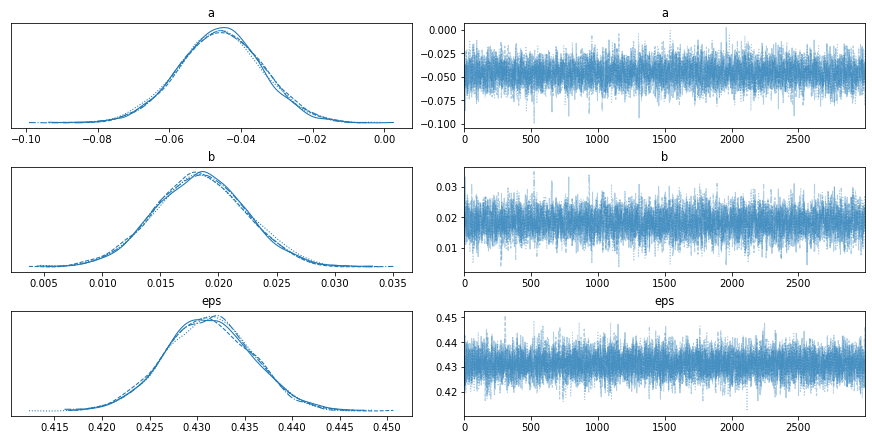

In [12]:
az.plot_trace(trace1)

In [13]:
az.summary(trace1)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
a    -0.046  0.012  -0.068   -0.024        0.0      0.0    4190.0    5117.0   
b[0]  0.018  0.004   0.011    0.026        0.0      0.0    4404.0    4793.0   
eps   0.431  0.005   0.422    0.440        0.0      0.0    6515.0    5953.0   

      r_hat  
a       1.0  
b[0]    1.0  
eps     1.0

In [14]:
# give random intercept
with pm.Model() as model2:
    a = pm.Normal('a', mu=0, sigma=2, shape=n_sub)
    b = pm.Normal('b', mu=0, sigma=2, shape=1)
    
    eps = pm.HalfCauchy('eps', 5)
    mu = a[subIDX] + b*condIDX
    
    y_hat = pm.Normal('y', mu=mu, sigma=eps, observed=df.coupling)
    
    trace2 = pm.sample(target_accept=.95, chains=4, cores=10, return_inferencedata=True, draws=2000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 10 jobs)
NUTS: [eps, b, a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 26 seconds.


array([[<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>],
       [<AxesSubplot:title={'center':'b'}>,
        <AxesSubplot:title={'center':'b'}>],
       [<AxesSubplot:title={'center':'eps'}>,
        <AxesSubplot:title={'center':'eps'}>]], dtype=object)

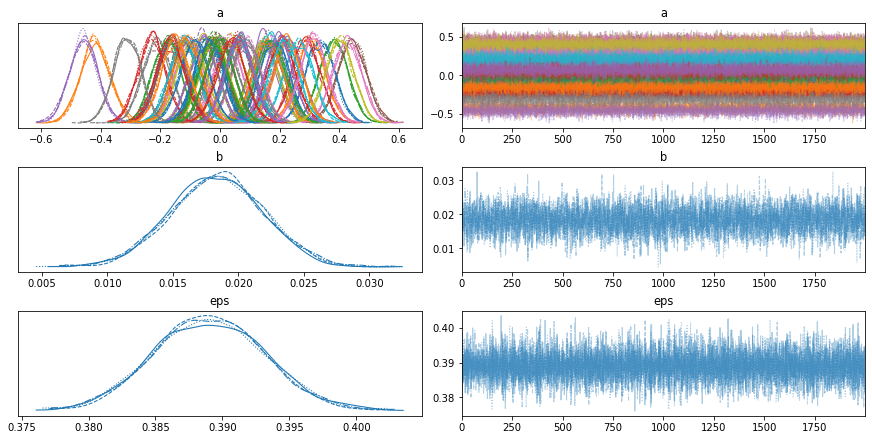

In [15]:
az.plot_trace(trace2)

In [16]:
az.summary(trace2)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
a[0]   0.062  0.048  -0.031    0.151        0.0    0.000   17449.0    5477.0   
a[1]  -0.419  0.049  -0.511   -0.327        0.0    0.000   16661.0    5251.0   
a[2]   0.382  0.047   0.294    0.470        0.0    0.000   18243.0    6020.0   
a[3]   0.068  0.048  -0.022    0.157        0.0    0.000   15188.0    4969.0   
a[4]   0.145  0.048   0.057    0.237        0.0    0.000   17471.0    5602.0   
...      ...    ...     ...      ...        ...      ...       ...       ...   
a[62] -0.001  0.048  -0.089    0.090        0.0    0.001   16790.0    5755.0   
a[63]  0.037  0.048  -0.049    0.131        0.0    0.000   16174.0    5474.0   
a[64]  0.065  0.046  -0.023    0.149        0.0    0.000   16702.0    6258.0   
b[0]   0.018  0.004   0.012    0.025        0.0    0.000    4602.0    6056.0   
eps    0.389  0.004   0.381    0.396        0.0    0.000   16216.0    5315.0   

       r_hat  
a[0]     1.0  
a[1]     1.0  
a[2]     1.0  
a[3]     1.0  
a[4]     1.0  
...      ...  
a[62]    1.0  
a[63]    1.0  
a[64]    1.0  
b[0]     1.0  
eps      1.0  

[67 rows x 9 columns]

In [18]:
# adding trials
# give random intercept
with pm.Model() as model3:
    a = pm.Normal('a', mu=0, sigma=2, shape=n_sub)
    b = pm.Normal('b', mu=0, sigma=2, shape=n_sub)
    #b2 = pm.Normal('b2', mu=0, sigma=2)#, shape=nTrials)
    eps = pm.HalfCauchy('eps', 5)
    mu = a[subIDX] + b[subIDX]*condIDX 
    
    y_hat = pm.Normal('y', mu=mu, sigma=eps, observed=df.coupling)
    
    trace3 = pm.sample(target_accept=.95, chains=4, cores=10, return_inferencedata=True, draws=3000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 10 jobs)
NUTS: [eps, b, a]


Sampling 4 chains for 2_000 tune and 3_000 draw iterations (8_000 + 12_000 draws total) took 79 seconds.


array([[<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>],
       [<AxesSubplot:title={'center':'b'}>,
        <AxesSubplot:title={'center':'b'}>],
       [<AxesSubplot:title={'center':'eps'}>,
        <AxesSubplot:title={'center':'eps'}>]], dtype=object)

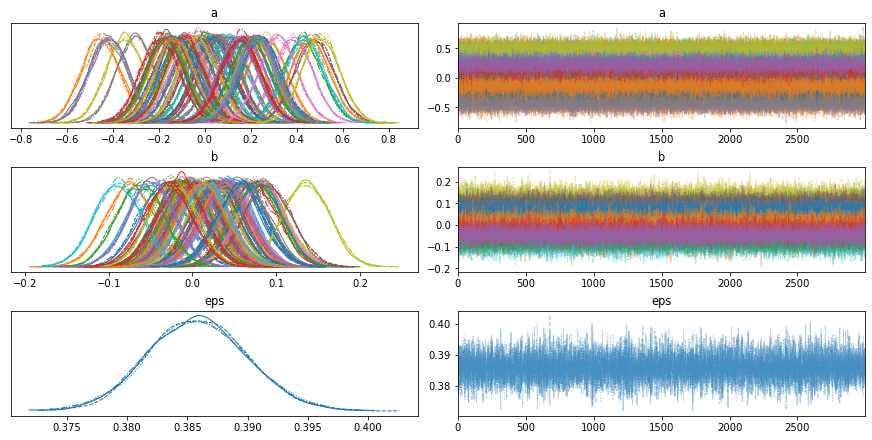

In [19]:
az.plot_trace(trace3)

In [20]:
az.compare({'model1': trace1, 'model2': trace2, 'model3': trace3})

/gpfs/ysm/project/joormann/oad4/conda_envs/neuroAnalysis/lib/python3.9/site-packages/arviz/stats/stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(


rank          loo       p_loo       d_loo    weight         se  \
model3     0 -2158.680307  128.457577    0.000000  0.541239  42.662611   
model2     1 -2162.813818   66.166858    4.133511  0.412477  41.861133   
model1     2 -2591.750047    2.644520  433.069740  0.046285  37.387080   

              dse  warning loo_scale  
model3   0.000000    False       log  
model2  12.000974    False       log  
model1  32.177007    False       log

In [50]:
with pm.Model() as model4:
    # hyper for condition
    b_cond = pm.Normal('b_cond', mu=0, sigma=.5, shape=n_cond)
   
    a = pm.Normal('a', mu=0, sigma=.5, shape=n_sub)
  
    eps = pm.HalfCauchy('eps', .5)
  
    mu = a[subIDX] + b_cond[condIDX]
    
    y_hat = pm.Normal('y', mu=mu, sigma=eps, observed=df.coupling)
    
    trace4 = pm.sample(target_accept=.95, chains=4, cores=10, return_inferencedata=True, draws=2000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 10 jobs)
NUTS: [eps, a, b_cond]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 34 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


array([[<AxesSubplot:title={'center':'b_cond'}>,
        <AxesSubplot:title={'center':'b_cond'}>],
       [<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>],
       [<AxesSubplot:title={'center':'eps'}>,
        <AxesSubplot:title={'center':'eps'}>]], dtype=object)

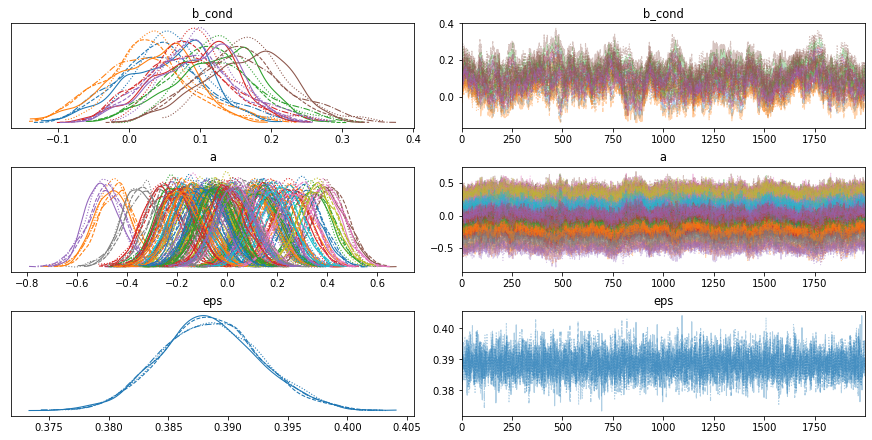

In [51]:
az.plot_trace(trace4)

In [52]:
az.summary(trace4, var_names='b_cond')

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
b_cond[0]  0.052  0.060  -0.059    0.170      0.007    0.005      65.0   
b_cond[1]  0.029  0.060  -0.091    0.140      0.007    0.005      69.0   
b_cond[2]  0.120  0.062   0.006    0.242      0.007    0.006      71.0   
b_cond[3]  0.087  0.060  -0.030    0.195      0.008    0.005      64.0   
b_cond[4]  0.093  0.059  -0.023    0.204      0.007    0.005      67.0   
b_cond[5]  0.161  0.061   0.050    0.283      0.008    0.006      66.0   

           ess_tail  r_hat  
b_cond[0]     179.0   1.06  
b_cond[1]     184.0   1.06  
b_cond[2]     177.0   1.06  
b_cond[3]     191.0   1.06  
b_cond[4]     179.0   1.06  
b_cond[5]     175.0   1.06

In [41]:
az.compare({'model1': trace1, 'model2': trace2, 'model3': trace3, 'model4': trace4})

/gpfs/ysm/project/joormann/oad4/conda_envs/neuroAnalysis/lib/python3.9/site-packages/arviz/stats/stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
/gpfs/ysm/project/joormann/oad4/conda_envs/neuroAnalysis/lib/python3.9/site-packages/arviz/stats/stats.py:876: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/gpfs/ysm/project/joormann/oad4/conda_envs/neuroAnalysis/lib/python3.9/site-packages/numpy/core/_methods.py:48: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


rank          loo       p_loo       d_loo    weight         se  \
model4     0 -2158.470529   69.684394    0.000000  0.453698  41.736732   
model3     1 -2158.680307  128.457577    0.209778  0.507026  42.662611   
model2     2 -2162.813818   66.166858    4.343289  0.000000  41.861133   
model1     3 -2591.750047    2.644520  433.279518  0.039277  37.387080   

              dse  warning loo_scale  
model4   0.000000    False       log  
model3  12.679755    False       log  
model2   4.109188    False       log  
model1  29.954062    False       log

<AxesSubplot:>

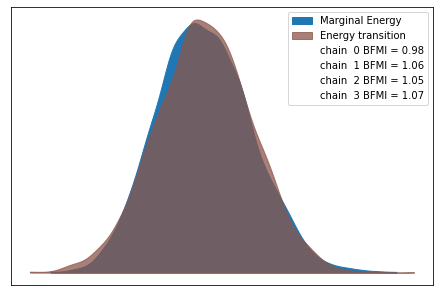

In [43]:
az.plot_energy(trace4)

In [59]:
# add hyperpriors
with pm.Model() as model5:
    
    
    mu_a = pm.Normal('mu_a', mu=0, sigma=.5)
    sigma_a = pm.HalfCauchy('sigma_a', .5)
    
    mu_b = pm.Normal('mu_b', mu=0, sigma=.5)
    sigma_b = pm.HalfCauchy('sigma_b', .5)
    
    b_cond = pm.Normal('b_cond', mu=mu_b, sigma=sigma_b, shape=n_cond)
   
    a = pm.Normal('a', mu=mu_a, sigma=sigma_a, shape=n_sub)
  
    eps = pm.HalfCauchy('eps', .5)
  
    mu = a[subIDX] + b_cond[condIDX]
    
    y_hat = pm.Normal('y', mu=mu, sigma=eps, observed=df.coupling)
    
    trace5 = pm.sample(target_accept=.95, chains=4, cores=10, return_inferencedata=True, draws=2000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 10 jobs)
NUTS: [eps, a, b_cond, sigma_b, mu_b, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 54 seconds.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


array([[<AxesSubplot:title={'center':'mu_a'}>,
        <AxesSubplot:title={'center':'mu_a'}>],
       [<AxesSubplot:title={'center':'mu_b'}>,
        <AxesSubplot:title={'center':'mu_b'}>],
       [<AxesSubplot:title={'center':'b_cond'}>,
        <AxesSubplot:title={'center':'b_cond'}>],
       [<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>],
       [<AxesSubplot:title={'center':'sigma_a'}>,
        <AxesSubplot:title={'center':'sigma_a'}>],
       [<AxesSubplot:title={'center':'sigma_b'}>,
        <AxesSubplot:title={'center':'sigma_b'}>],
       [<AxesSubplot:title={'center':'eps'}>,
        <AxesSubplot:title={'center':'eps'}>]], dtype=object)

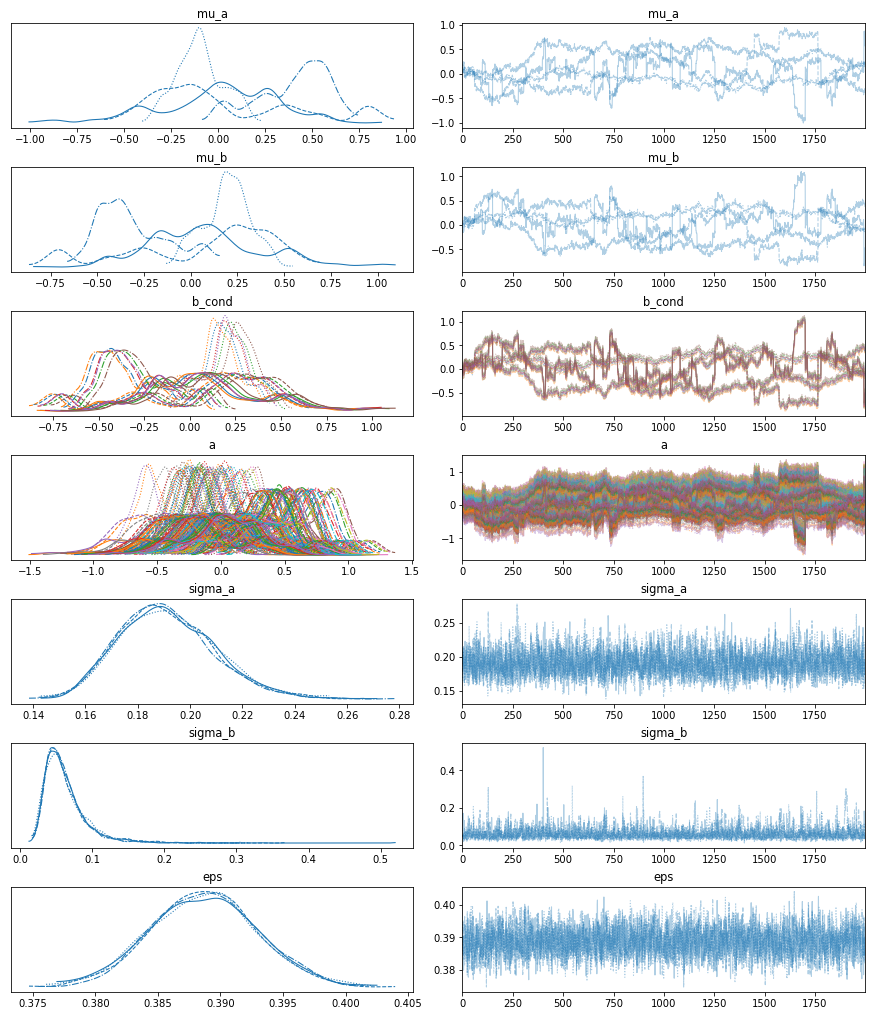

In [60]:
az.plot_trace(trace5)

In [62]:
az.compare({'model3': trace3, 'model4': trace4, 'model5':trace5})

/gpfs/ysm/project/joormann/oad4/conda_envs/neuroAnalysis/lib/python3.9/site-packages/arviz/stats/stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
/gpfs/ysm/project/joormann/oad4/conda_envs/neuroAnalysis/lib/python3.9/site-packages/arviz/stats/stats.py:876: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/gpfs/ysm/project/joormann/oad4/conda_envs/neuroAnalysis/lib/python3.9/site-packages/numpy/core/_methods.py:48: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/gpfs/ysm/project/joormann/oad4/conda_envs/neuroAnalysis/lib/python3.9/site-packages/arviz/stats/stats.py:876: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/gpfs/ysm/project/joormann/oad4/conda_envs/neuroAnalysis/lib/python3.9/site-packages/n

rank          loo       p_loo     d_loo    weight         se  \
model5     0 -2157.228343   66.436289  0.000000  0.503721  41.307746   
model4     1 -2158.524260   69.731959  1.295917  0.000000  41.728321   
model3     2 -2158.680307  128.457577  1.451964  0.496279  42.662611   

              dse  warning loo_scale  
model5   0.000000    False       log  
model4   1.651153    False       log  
model3  12.706554    False       log

In [100]:
# use reparametarization of the same model
# add hyperpriors
with pm.Model() as model6:
    
    
    mu_a = pm.Normal('mu_a', mu=0, sigma=.5)
    sigma_a = pm.HalfCauchy('sigma_a', .5)
    a_matt = pm.Normal('a_matt', mu=0, sd=1, shape=n_sub)
    a = pm.Deterministic('a', mu_a + sigma_a*a_matt)
    
    mu_b = pm.Normal('mu_b', mu=0, sigma=.5)
    sigma_b = pm.HalfCauchy('sigma_b', .5)
    b_matt = pm.Normal('b_matt', mu=0, sigma=1, shape=n_cond)
    b_cond = pm.Deterministic('b_cond', mu_b + sigma_b*b_matt)
    
    # add trials and amygdala activation
    b_trials = pm.Normal('b_trials', mu=0, sigma=.5)
    b_amg = pm.Normal('b_amg', mu=0, sigma=.5)
   
    a = pm.Deterministic('a', mu_a + sigma_a*a_matt)
  
    eps = pm.HalfCauchy('eps', .5)
    
    # make mu a determenistic distribution so we can test later vs. actual data
    
    mu = pm.Deterministic('mu',a[subIDX] + b_cond[condIDX] + b_trials*trials + b_amg*df.amg)
    
    y_hat = pm.Normal('y_hat', mu=mu, sigma=eps, observed=df.coupling)
    
    trace6 = pm.sample(target_accept=.95, chains=4, cores=10, return_inferencedata=True, draws=2000, tune=2000)    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 10 jobs)
NUTS: [eps, b_amg, b_trials, b_matt, sigma_b, mu_b, a_matt, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 512 seconds.
The number of effective samples is smaller than 25% for some parameters.


array([[<AxesSubplot:title={'center':'mu_a'}>,
        <AxesSubplot:title={'center':'mu_a'}>],
       [<AxesSubplot:title={'center':'a_matt'}>,
        <AxesSubplot:title={'center':'a_matt'}>],
       [<AxesSubplot:title={'center':'mu_b'}>,
        <AxesSubplot:title={'center':'mu_b'}>],
       [<AxesSubplot:title={'center':'b_matt'}>,
        <AxesSubplot:title={'center':'b_matt'}>],
       [<AxesSubplot:title={'center':'b_trials'}>,
        <AxesSubplot:title={'center':'b_trials'}>],
       [<AxesSubplot:title={'center':'b_amg'}>,
        <AxesSubplot:title={'center':'b_amg'}>],
       [<AxesSubplot:title={'center':'sigma_a'}>,
        <AxesSubplot:title={'center':'sigma_a'}>],
       [<AxesSubplot:title={'center':'sigma_b'}>,
        <AxesSubplot:title={'center':'sigma_b'}>],
       [<AxesSubplot:title={'center':'b_cond'}>,
        <AxesSubplot:title={'center':'b_cond'}>],
       [<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>],
       [<AxesSubplot:t

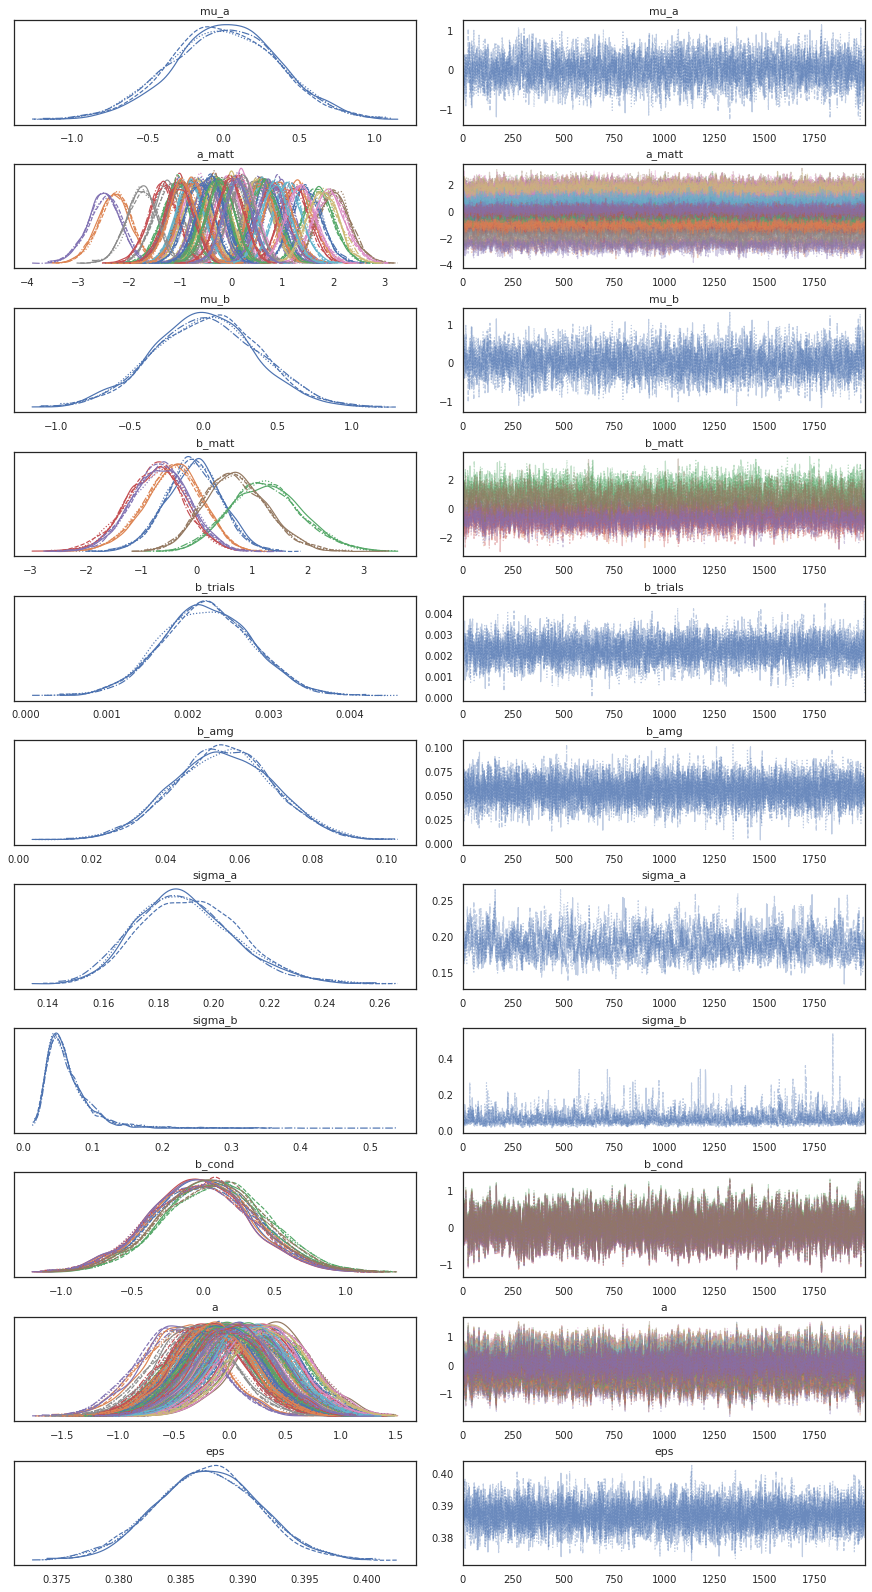

In [101]:
az.plot_trace(trace6)

In [102]:
az.summary(trace6, var_names=['b_cond','b_matt'])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
b_cond[0]  0.015  0.353  -0.643    0.690      0.006    0.004    3157.0   
b_cond[1] -0.004  0.353  -0.683    0.651      0.006    0.004    3161.0   
b_cond[2]  0.088  0.354  -0.556    0.778      0.006    0.004    3169.0   
b_cond[3] -0.024  0.353  -0.702    0.637      0.006    0.004    3149.0   
b_cond[4] -0.019  0.354  -0.696    0.645      0.006    0.004    3149.0   
b_cond[5]  0.056  0.354  -0.593    0.740      0.006    0.004    3154.0   
b_matt[0] -0.071  0.497  -0.989    0.878      0.010    0.007    2383.0   
b_matt[1] -0.442  0.524  -1.476    0.484      0.011    0.008    2399.0   
b_matt[2]  1.242  0.649   0.070    2.500      0.013    0.009    2535.0   
b_matt[3] -0.759  0.529  -1.733    0.265      0.010    0.007    2519.0   
b_matt[4] -0.667  0.519  -1.624    0.345      0.010    0.007    2468.0   
b_matt[5]  0.694  0.575  -0.371    1.782      0.011    0.008    2547.0   

           ess_tail  r_hat  
b_cond[0]    4727.0    1.0  
b_cond[1]    4716.0    1.0  
b_cond[2]    4744.0    1.0  
b_cond[3]    4717.0    1.0  
b_cond[4]    4716.0    1.0  
b_cond[5]    4851.0    1.0  
b_matt[0]    3994.0    1.0  
b_matt[1]    4033.0    1.0  
b_matt[2]    4018.0    1.0  
b_matt[3]    4016.0    1.0  
b_matt[4]    3789.0    1.0  
b_matt[5]    4788.0    1.0

In [74]:
az.compare({'model3': trace3, 'model4': trace4, 'model5':trace5, 'model6':trace6})

/gpfs/ysm/project/joormann/oad4/conda_envs/neuroAnalysis/lib/python3.9/site-packages/arviz/stats/stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
/gpfs/ysm/project/joormann/oad4/conda_envs/neuroAnalysis/lib/python3.9/site-packages/arviz/stats/stats.py:876: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/gpfs/ysm/project/joormann/oad4/conda_envs/neuroAnalysis/lib/python3.9/site-packages/numpy/core/_methods.py:48: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/gpfs/ysm/project/joormann/oad4/conda_envs/neuroAnalysis/lib/python3.9/site-packages/arviz/stats/stats.py:876: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/gpfs/ysm/project/joormann/oad4/conda_envs/neuroAnalysis/lib/python3.9/site-packages/n

rank          loo       p_loo     d_loo        weight         se  \
model5     0 -2157.228343   66.436289  0.000000  5.037195e-01  41.307746   
model6     1 -2157.235262   66.535220  0.006919  0.000000e+00  41.347988   
model4     2 -2158.524260   69.731959  1.295917  1.110223e-16  41.728321   
model3     3 -2158.680307  128.457577  1.451964  4.962805e-01  42.662611   

              dse  warning loo_scale  
model5   0.000000    False       log  
model6   0.117187    False       log  
model4   1.651153    False       log  
model3  12.706554    False       log

array([<AxesSubplot:>], dtype=object)

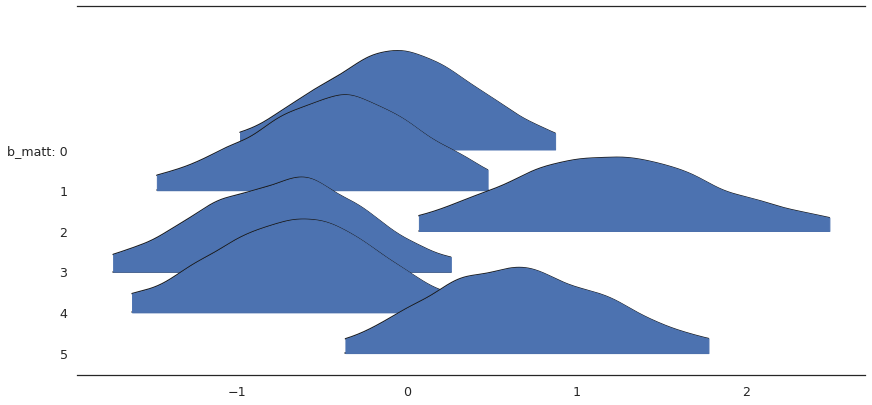

In [103]:
az.plot_forest(trace6, var_names='b_matt',
               combined=True, kind="ridgeplot",
              ridgeplot_truncate=True, 
               )

<AxesSubplot:>

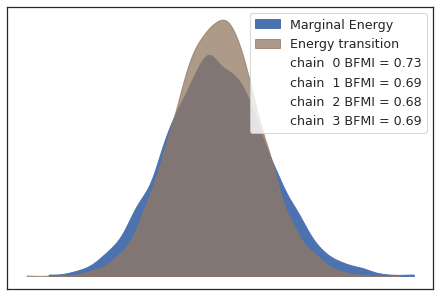

In [104]:
az.plot_energy(trace6)

In [92]:
trStacked = trace6.posterior.stack(draws=('chain','draw'))


#### Remember the order to use for comparison
'CSminus1':0, 'CSplus1':1, 'CSplusUS1':2, 'CSplus2':3, 'CSminus2':4, 'CSminusUS2':5

In [109]:
trStacked.b_cond.shape

(6, 8000)

In [123]:
csminus1 = trStacked.b_cond[0,:].values
csplus1 = trStacked.b_cond[1,:].values
csPlusUS1 = trStacked.b_cond[2,:].values


<AxesSubplot:ylabel='Count'>

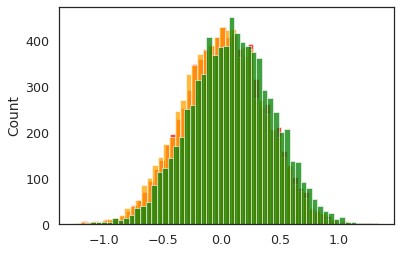

In [124]:
sns.histplot(csminus1, color='red')
sns.histplot(csplus1, color='orange')
sns.histplot(csPlusUS1, color='green')

Text(0.5, 1.0, 'CSPlusUS1-CSplus1')

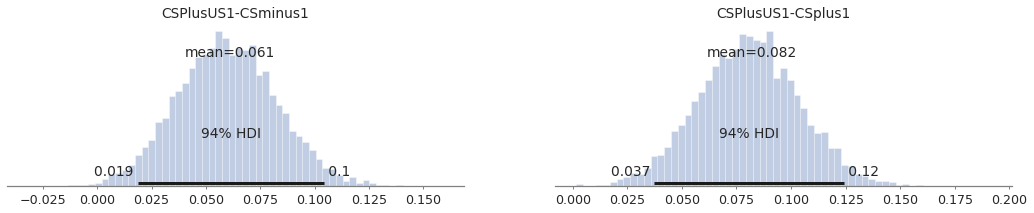

In [134]:
delta = csPlusUS1-csminus1
delta.shape

fig, axes = plt.subplots(1,2, figsize=(18,3))
az.plot_posterior(delta, point_estimate='mean', kind='hist', ax=axes[0])
axes[0].set_title("CSPlusUS1-CSminus1")

az.plot_posterior(csPlusUS1-csplus1, point_estimate='mean', kind='hist', ax=axes[1])
axes[1].set_title("CSPlusUS1-CSplus1")


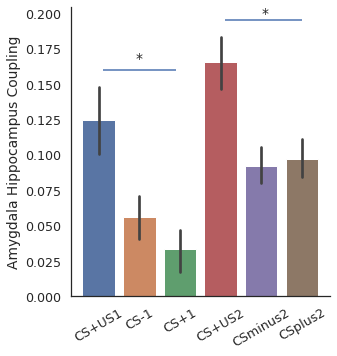

In [98]:
sns.set(font_scale = 1.15)
sns.set_style("white")
g = sns.catplot(y='coupling',x='condition', data=df, kind='bar', ci=68)
g.set_xlabels("")
g.set_xticklabels(
    labels=["CS+US1", "CS-1", "CS+1", "CS+US2", "CSminus2", "CSplus2"], rotation=30)
plt.text(0.9, 0.165, "*")
plt.hlines(0.16, 0.1,1.9)
plt.text(4, 0.197, "*")
plt.hlines(0.195, 3.1,5)
g.set_ylabels("Amygdala Hippocampus Coupling")
g.savefig('coupling_different_Conditions.png', dpi=300, bbox_inches='tight')

In [135]:
# try same model with much more samples
with model6:  
    trace7 = pm.sample(target_accept=.95, chains=4, cores=10, return_inferencedata=True, draws=5000, tune=5000)    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 10 jobs)
NUTS: [eps, b_amg, b_trials, b_matt, sigma_b, mu_b, a_matt, sigma_a, mu_a]


Sampling 4 chains for 5_000 tune and 5_000 draw iterations (20_000 + 20_000 draws total) took 1214 seconds.
The number of effective samples is smaller than 25% for some parameters.


array([[<AxesSubplot:title={'center':'mu_a'}>,
        <AxesSubplot:title={'center':'mu_a'}>],
       [<AxesSubplot:title={'center':'a_matt'}>,
        <AxesSubplot:title={'center':'a_matt'}>],
       [<AxesSubplot:title={'center':'mu_b'}>,
        <AxesSubplot:title={'center':'mu_b'}>],
       [<AxesSubplot:title={'center':'b_matt'}>,
        <AxesSubplot:title={'center':'b_matt'}>],
       [<AxesSubplot:title={'center':'b_trials'}>,
        <AxesSubplot:title={'center':'b_trials'}>],
       [<AxesSubplot:title={'center':'b_amg'}>,
        <AxesSubplot:title={'center':'b_amg'}>],
       [<AxesSubplot:title={'center':'sigma_a'}>,
        <AxesSubplot:title={'center':'sigma_a'}>],
       [<AxesSubplot:title={'center':'sigma_b'}>,
        <AxesSubplot:title={'center':'sigma_b'}>],
       [<AxesSubplot:title={'center':'b_cond'}>,
        <AxesSubplot:title={'center':'b_cond'}>],
       [<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>],
       [<AxesSubplot:t

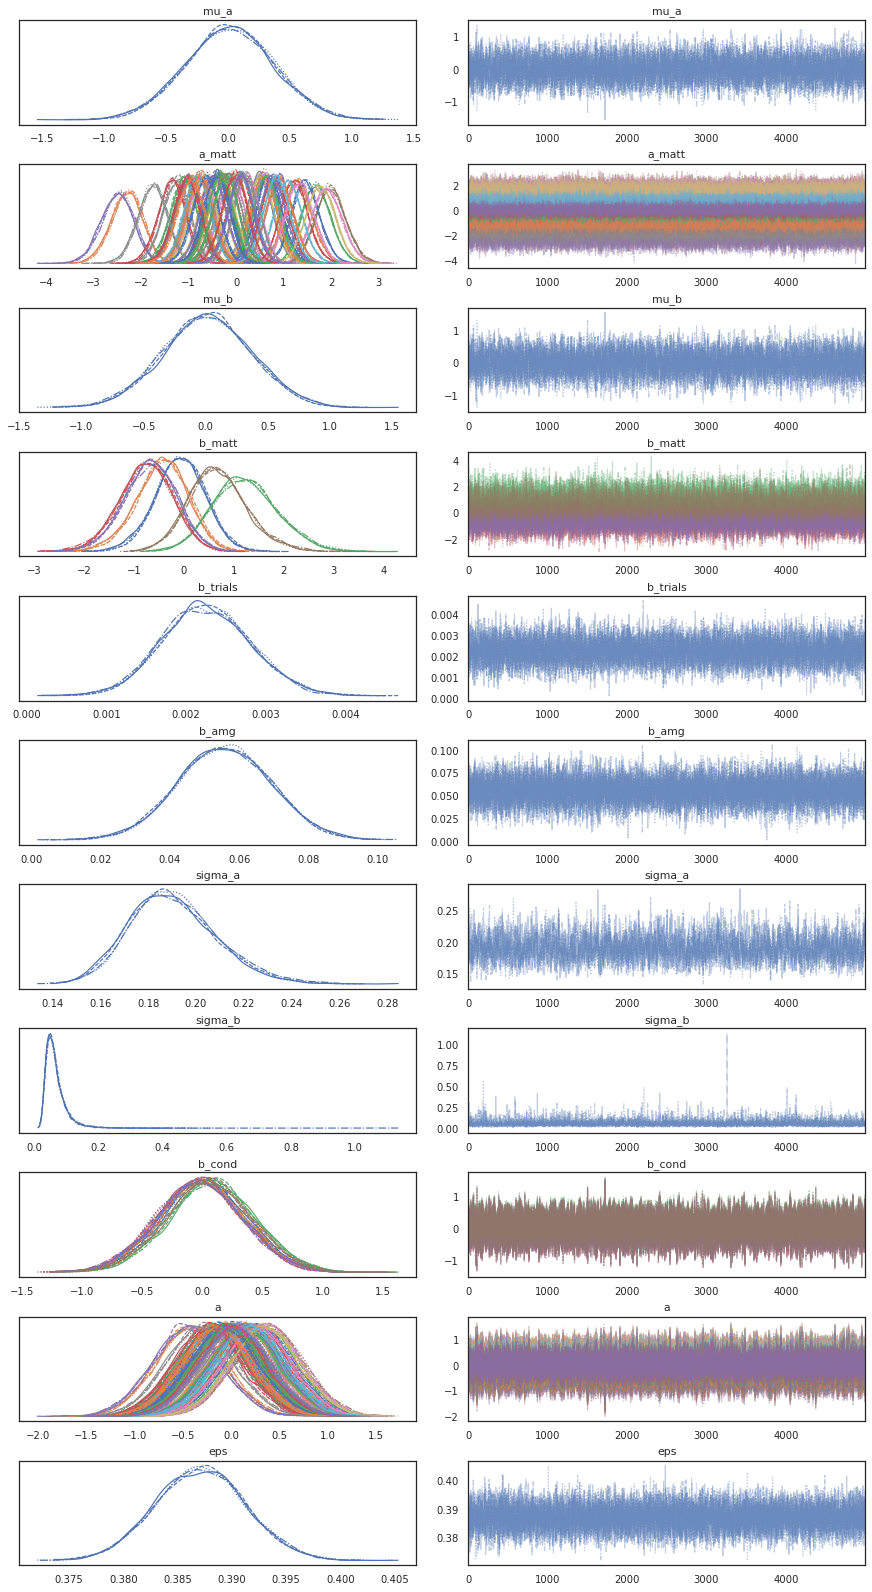

In [136]:
az.plot_trace(trace7)

In [137]:
trStacked2 = trace7.posterior.stack(draws=('chain','draw'))

In [138]:
csminus1 = trStacked2.b_cond[0,:].values
csplus1 = trStacked2.b_cond[1,:].values
csPlusUS1 = trStacked2.b_cond[2,:].values


<AxesSubplot:ylabel='Count'>

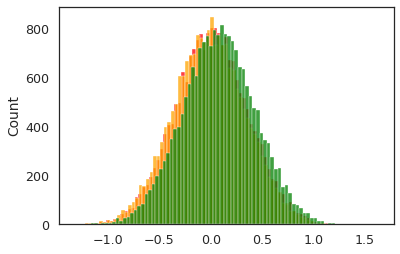

In [139]:
sns.histplot(csminus1, color='red')
sns.histplot(csplus1, color='orange')
sns.histplot(csPlusUS1, color='green')

Text(0.5, 1.0, 'CSPlusUS1-CSplus1')

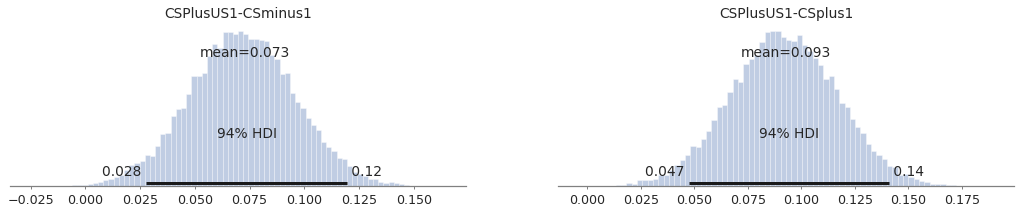

In [140]:
delta = csPlusUS1-csminus1
delta.shape

fig, axes = plt.subplots(1,2, figsize=(18,3))
az.plot_posterior(delta, point_estimate='mean', kind='hist', ax=axes[0])
axes[0].set_title("CSPlusUS1-CSminus1")

az.plot_posterior(csPlusUS1-csplus1, point_estimate='mean', kind='hist', ax=axes[1])
axes[1].set_title("CSPlusUS1-CSplus1")


In [141]:
az.summary(trace7, var_names=['b_matt','b_cond','mu_b','mu_a'])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
b_matt[0] -0.069  0.503  -1.038    0.859      0.006    0.004    6492.0   
b_matt[1] -0.433  0.524  -1.438    0.528      0.007    0.005    6312.0   
b_matt[2]  1.230  0.650   0.022    2.455      0.008    0.005    7007.0   
b_matt[3] -0.762  0.535  -1.764    0.243      0.007    0.005    6035.0   
b_matt[4] -0.670  0.527  -1.665    0.316      0.007    0.005    6070.0   
b_matt[5]  0.679  0.586  -0.375    1.865      0.007    0.005    6892.0   
b_cond[0]  0.006  0.354  -0.661    0.672      0.004    0.002   10158.0   
b_cond[1] -0.014  0.354  -0.695    0.634      0.004    0.002   10153.0   
b_cond[2]  0.079  0.354  -0.580    0.752      0.004    0.002   10191.0   
b_cond[3] -0.034  0.354  -0.718    0.613      0.004    0.002   10242.0   
b_cond[4] -0.029  0.354  -0.708    0.624      0.004    0.002   10244.0   
b_cond[5]  0.046  0.354  -0.628    0.704      0.004    0.002   10145.0   
mu_b       0.010  0.354  -0.643    0.689      0.004    0.003    9939.0   
mu_a       0.016  0.353  -0.644    0.683      0.004    0.002   10168.0   

           ess_tail  r_hat  
b_matt[0]    9805.0    1.0  
b_matt[1]   10318.0    1.0  
b_matt[2]   10897.0    1.0  
b_matt[3]    9818.0    1.0  
b_matt[4]   10412.0    1.0  
b_matt[5]   10253.0    1.0  
b_cond[0]   12053.0    1.0  
b_cond[1]   12114.0    1.0  
b_cond[2]   12423.0    1.0  
b_cond[3]   11994.0    1.0  
b_cond[4]   11956.0    1.0  
b_cond[5]   12187.0    1.0  
mu_b        11919.0    1.0  
mu_a        12316.0    1.0

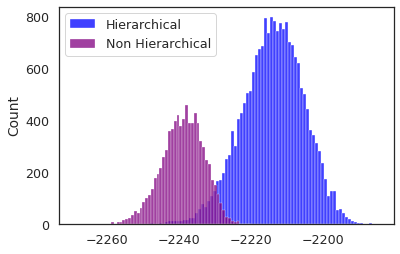

In [146]:
# calculate logP
logP = trace7.sample_stats.lp.stack(draws=('chain','draw'))
logP1 = trace2.sample_stats.lp.stack(draws=('chain','draw'))
sns.histplot(logP, label='Hierarchical', color='blue')
sns.histplot(logP1, label='Non Hierarchical', color='purple')
plt.legend()

### Posterior predictive checks

In [147]:
with model6:
    ppc = pm.sample_posterior_predictive(trace7)

In [152]:
az.from_pymc3(posterior_predictive=ppc, model=model6)

Inference data with groups:
	> posterior_predictive
	> observed_data

<AxesSubplot:xlabel='y'>

/gpfs/ysm/project/joormann/oad4/conda_envs/neuroAnalysis/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


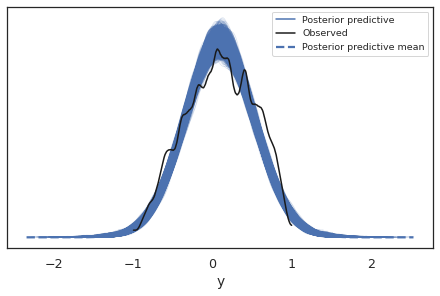

In [153]:
# plot
az.plot_ppc(az.from_pymc3(posterior_predictive=ppc, model=model6), var_names='y')

## Next: Assessing SCR using coupling
- Now we will test SCR as predicted variable and coupling as predictor (independent)

In [154]:
glm2 = smf.mixedlm('scr~ coupling + C(condition) + trialNo+ amg', data=df, 
    groups = 'subject', 
                 missing='drop')
model2_f = glm2.fit()
print(model2_f.summary())

                Mixed Linear Model Regression Results
Model:                  MixedLM     Dependent Variable:     scr       
No. Observations:       4485        Method:                 REML      
No. Groups:             65          Scale:                  0.3783    
Min. group size:        69          Log-Likelihood:         -4330.8159
Max. group size:        69          Converged:              Yes       
Mean group size:        69.0                                          
----------------------------------------------------------------------
                           Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------------------
Intercept                   0.447    0.067   6.686 0.000  0.316  0.578
C(condition)[T.CSminus2]    0.309    0.044   7.083 0.000  0.224  0.395
C(condition)[T.CSminusUS2]  0.519    0.045  11.459 0.000  0.431  0.608
C(condition)[T.CSplus1]     0.230    0.031   7.370 0.000  0.169  0.291
C(condition)[T.CSplus2]

## Bayes
- We are going to use the same model we chose (model6)

In [167]:
# use reparametarization of the same model
# add hyperpriors
with pm.Model() as model1_scr:
    
    
    mu_a = pm.Normal('mu_a', mu=0, sigma=.5)
    sigma_a = pm.HalfCauchy('sigma_a', .5)
    a_matt = pm.Normal('a_matt', mu=0, sd=1, shape=n_sub)
    a = pm.Deterministic('a', mu_a + sigma_a*a_matt)
        
    mu_b = pm.Normal('mu_b', mu=0, sigma=.5)
    sigma_b = pm.HalfCauchy('sigma_b', .5)
    b_matt = pm.Normal('b_matt', mu=0, sigma=1, shape=n_cond)
    b_cond = pm.Deterministic('b_cond', mu_b + sigma_b*b_matt)
    
    # add trials and amygdala activation
    b_trials = pm.Normal('b_trials', mu=0, sigma=.5)
    b_amg = pm.Normal('b_amg', mu=0, sigma=.5)
    
    # add coupling
    b_coup = pm.Normal('b_coup', mu=0, sigma=.5)
    
    
  
    eps = pm.HalfCauchy('eps', .5)
    
    # make mu a determenistic distribution so we can test later vs. actual data
    
    mu = pm.Deterministic('mu',a[subIDX] + b_cond[condIDX] + b_trials*trials + b_amg*df.amg + b_coup*df.coupling)
    
    y_hat = pm.Normal('y_hat', mu=mu, sigma=eps, observed=df.scr)
   
    
    trace1_scr = pm.sample(target_accept=.95, chains=4, cores=10, return_inferencedata=True, draws=2000, tune=2000)    

SamplingError: Initial evaluation of model at starting point failed!
Starting values:
{'mu_a': array(0.), 'sigma_a_log__': array(-0.69314718), 'a_matt': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'mu_b': array(0.), 'sigma_b_log__': array(-0.69314718), 'b_matt': array([0., 0., 0., 0., 0., 0.]), 'b_trials': array(0.), 'b_amg': array(0.), 'b_coup': array(0.), 'eps_log__': array(-0.69314718)}

Initial evaluation results:
mu_a             -0.23
sigma_a_log__    -1.14
a_matt          -59.73
mu_b             -0.23
sigma_b_log__    -1.14
b_matt           -5.51
b_trials         -0.23
b_amg            -0.23
b_coup           -0.23
eps_log__        -1.14
y_hat             -inf
Name: Log-probability of test_point, dtype: float64

In [156]:
az.summary(trace1_scr, var_names=['b_coup', 'b_cond'])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
b_coup     0.057  0.024   0.013    0.102      0.000    0.000    8826.0   
b_cond[0]  0.070  0.361  -0.601    0.752      0.005    0.004    5759.0   
b_cond[1]  0.298  0.361  -0.389    0.966      0.005    0.004    5729.0   
b_cond[2]  0.722  0.362   0.053    1.404      0.005    0.004    5730.0   
b_cond[3]  0.282  0.362  -0.388    0.977      0.005    0.004    5731.0   
b_cond[4]  0.376  0.362  -0.273    1.095      0.005    0.004    5735.0   
b_cond[5]  0.583  0.362  -0.102    1.260      0.005    0.004    5801.0   

           ess_tail  r_hat  
b_coup       6487.0    1.0  
b_cond[0]    5158.0    1.0  
b_cond[1]    5107.0    1.0  
b_cond[2]    5309.0    1.0  
b_cond[3]    5256.0    1.0  
b_cond[4]    5191.0    1.0  
b_cond[5]    5289.0    1.0

array([[<AxesSubplot:title={'center':'b_coup'}>,
        <AxesSubplot:title={'center':'b_cond\n0'}>,
        <AxesSubplot:title={'center':'b_cond\n1'}>],
       [<AxesSubplot:title={'center':'b_cond\n2'}>,
        <AxesSubplot:title={'center':'b_cond\n3'}>,
        <AxesSubplot:title={'center':'b_cond\n4'}>],
       [<AxesSubplot:title={'center':'b_cond\n5'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

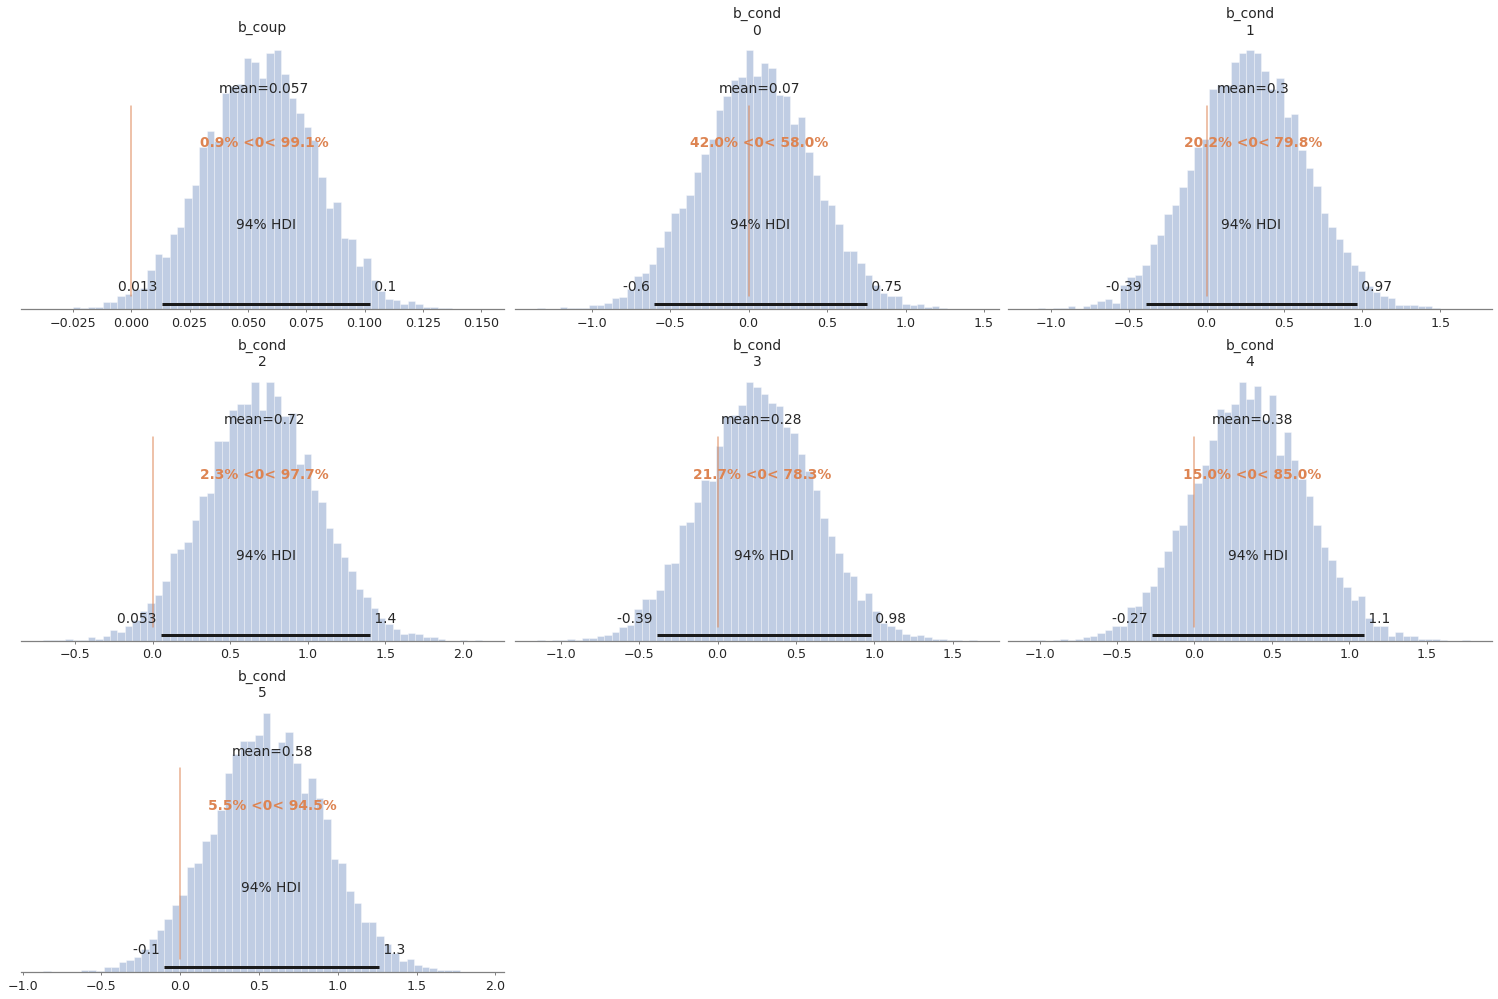

In [159]:
az.plot_posterior(trace1_scr, var_names=['b_coup','b_cond'], kind='hist', point_estimate='mean',
                 ref_val=0)

In [160]:
with model1_scr:
    ppc = pm.sample_posterior_predictive(trace1_scr)

<AxesSubplot:xlabel='y_hat'>

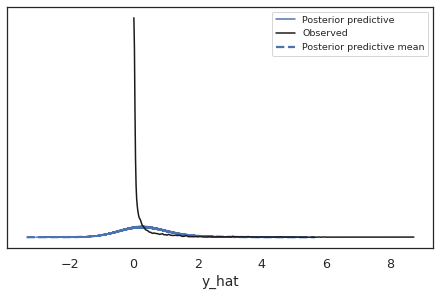

In [163]:
az.plot_ppc(az.from_pymc3(posterior_predictive=ppc, model=model1_scr), var_names='y_hat')

## Prediction error and coupling

In [169]:
with pm.Model() as model1_pe:
    
    
    mu_a = pm.Normal('mu_a', mu=0, sigma=.5)
    sigma_a = pm.HalfCauchy('sigma_a', .5)
    a_matt = pm.Normal('a_matt', mu=0, sd=1, shape=n_sub)
    a = pm.Deterministic('a', mu_a + sigma_a*a_matt)
        
    
    # add trials and amygdala activation
    b_trials = pm.Normal('b_trials', mu=0, sigma=.5)
    b_amg = pm.Normal('b_amg', mu=0, sigma=.5)
    
    # add coupling
    b_coup = pm.Normal('b_coup', mu=0, sigma=.5)
    
    
  
    eps = pm.HalfCauchy('eps', .5)
    
    # make mu a determenistic distribution so we can test later vs. actual data
    
    mu = pm.Deterministic('mu',a[subIDX] + b_trials*trials + b_amg*df.amg + b_coup*df.coupling)
    
    y_hat = pm.Normal('y_hat', mu=mu, sigma=eps, observed=df.pe)
   
    
    trace1_pe = pm.sample(target_accept=.95, chains=4, cores=10, return_inferencedata=True, draws=2000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 10 jobs)
NUTS: [eps, b_coup, b_amg, b_trials, a_matt, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 120 seconds.


In [ ]:
az.plot_trace(trace1_pe)

In [ ]:
az.summary(trace1_pe, var_names=['b_coup','b_amg','b_trials'])